In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

df=pd.read_csv("./data/atp_data.csv",low_memory=False)
df.Date = df.Date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

### 1. Données manquantes

In [115]:
df.isna().sum()

ATP              0
Location         0
Tournament       0
Date             0
Series           0
Court            0
Surface          0
Round            0
Best of         15
Winner           0
Loser            0
WRank            0
LRank            0
Wsets          302
Lsets          304
Comment          0
PSW           9186
PSL           9186
B365W         4061
B365L         4038
elo_winner       0
elo_loser        0
proba_elo        0
dtype: int64

Certaines cotes de paris sont absentes.

Les données sans cotes de paris restent utiles pour déterminer le profil par joueur, il est donc préférable de garder ces données.

### 2. Données erronées

<Axes: >

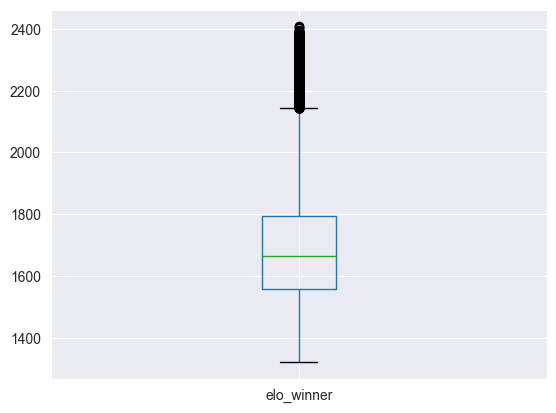

In [3]:
plt.figure()
df.boxplot(["elo_winner"])

### 3. Analyse

il y a plusieurs stratégies envisageables, on peut :
1. Mettre en concurrence les cotes de plusieurs bookmakers sur un même pari de manière à être positif quel que soit le résultat
2. Pour un bookmaker donné, mettre en place une stratégie pour ne parier que sur les matchs avec un écart de cotes très élevés
3. Evaluer les performances des joueurs pour déterminer la probabilité de victoire par joueur, sans considération des cotes des bookmakers

#### Stratégie 1 : Mettre en concurrence les cotes de plusieurs bookmakers sur un même pari de manière à être positif quel que soit le résultat

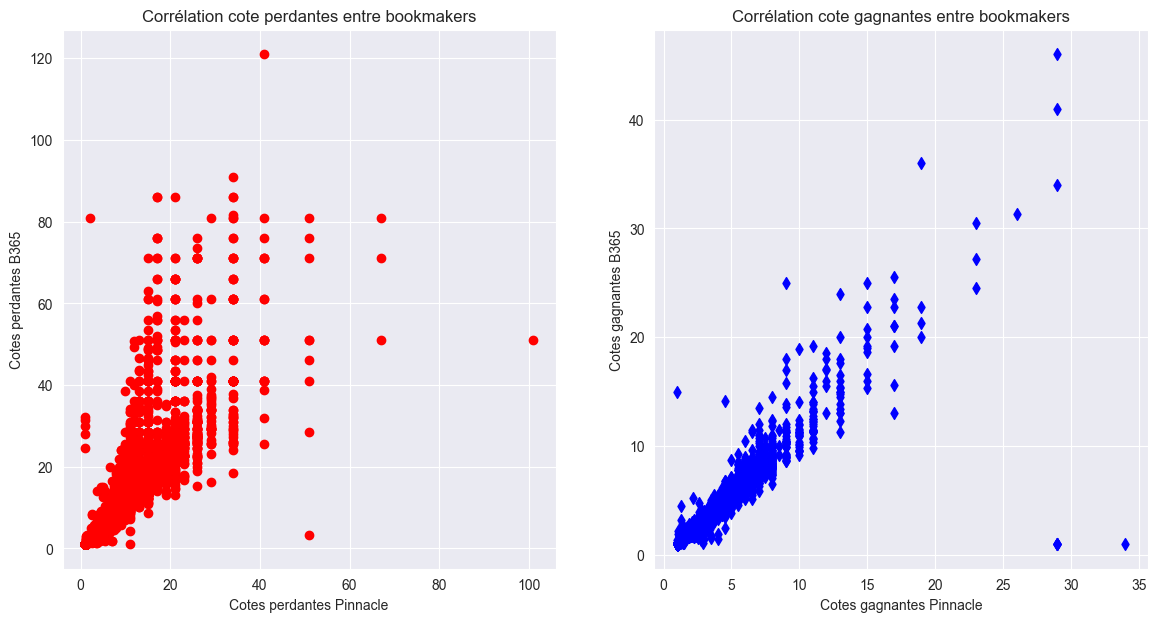

In [183]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.scatter(x=df['B365L'],y=df['PSL'],color='red',marker='o')
plt.xlabel("Cotes perdantes Pinnacle")
plt.ylabel("Cotes perdantes B365")
plt.title('Corrélation cote perdantes entre bookmakers')

plt.subplot(122)
plt.scatter(df['B365W'],df['PSW'],color='blue',marker='d')
plt.xlabel("Cotes gagnantes Pinnacle")
plt.ylabel("Cotes gagnantes B365")
plt.title('Corrélation cote gagnantes entre bookmakers')

plt.show()

Sans surprise les cotes des bookmakers sont corrélées.  
On remarque que les cotes des joueurs gagnants sont plus corrélées que les cotes perdantes.  
Le choix du bookmaker peut donc avoir son importance pour limiter les pertes des paris perdus.

In [97]:
len(df.loc[(df["PSW"] > 2) & (df["B365L"] > 2)])
#df.loc[(df["PSW"] > 2) & (df["B365L"] > 2)]

22

Il y a 22 match (en 22 ans) ou les bookmakers divergent avec une cote supérieure à 2.  
Parier simultanément chez les 2 bookmakers garantit à 100% un gain qui serait la cote -2 pour le bookmaker gagnant.  
Le nombre de match dans cette situation est rare et encourage à jouer de grosse somme lorsque la situation survient.  
En pratique, cette méthode est à prendre avec prudence, on observe chez la FDJ notamment des pratiques douteurs consistant à annuler certains paris sportifs pour "erreur manifeste de cotes".  
https://www.communique-presse-jeu.com/ads/erreur-manifeste-de-cotes-fdj/  
Il serait catastrophique de miser une grosse somme et de se voir refuser le pari gagnant...

#### Stratégie 2 : Pour un bookmaker donné, mettre en place une stratégie pour ne parier que sur les matchs avec un écart de cotes très élevés

In [5]:
# pour cette stratégie on drop les na
df_filtered = df.dropna()

In [6]:
# Parier 1 sur tous les matchs en prenant toujours la plus petite cote : 
# = toutes les plus petites cotes pour les parties gagnées - nb parties / nb parties

print(100*(df_filtered.PSW[df_filtered.PSL>df_filtered.PSW].sum() - len(df_filtered)) /len(df_filtered))
print("Si on pariait 1 euros sur 100 matchs sur la cote la plus petite, on perdrait en moyenne 1.92€")


-2.1904385152765005
Si on pariait 1 euros sur 100 matchs sur la cote la plus petite, on perdrait en moyenne 1.92€


In [7]:
# Parier 1 sur tous les matchs en prenant toujours la plus petite cote avec un ecart de cote de 2 minimum: 
ecart = 2 
small_psw_sum = df_filtered.PSW[df_filtered.PSL>ecart*df_filtered.PSW].sum()
total_games = df_filtered.PSW[df_filtered.PSL>ecart*df_filtered.PSW] + df_filtered.PSL[df_filtered.PSW>ecart*df_filtered.PSL]
print(100*(small_psw_sum - len(total_games)) /len(total_games))
print("Si on pariait 1 euros sur 100 matchs sur la cote la plus petite avec un ecart de cote de 2, on perdrait en moyenne 0.84€")


-0.8407315340908976
Si on pariait 1 euros sur 100 matchs sur la cote la plus petite avec un ecart de cote de 2, on perdrait en moyenne 0.84€


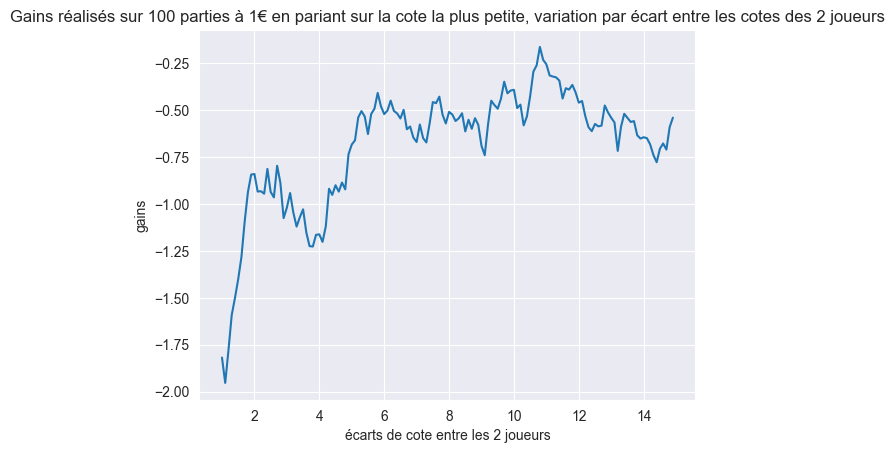

In [8]:
# graphe des petites cotes en faisant varier l'écart de cote 
ecarts = np.arange(1,15,0.1)
probas=[]
for ecart in ecarts:
    small_psw_sum = df_filtered.PSW[df_filtered.PSL>ecart*df_filtered.PSW].sum()
    total_games = df_filtered.PSW[df_filtered.PSL>ecart*df_filtered.PSW] + df_filtered.PSL[df_filtered.PSW>ecart*df_filtered.PSL]
    proba = 100*(small_psw_sum - len(total_games)) /len(total_games)
    probas.append(proba)

plt.plot(ecarts,probas)
plt.title("Gains réalisés sur 100 parties à 1€ en pariant sur la cote la plus petite, variation par écart entre les cotes des 2 joueurs")
plt.xlabel("écarts de cote entre les 2 joueurs")
plt.ylabel("gains")
plt.show()

On en conclue que la stratégie 3 n'est pas fiable car aucun écart de cote ne permet de réaliser un gain avec une stratégie consistant à toujours parier sur la cote la plus petite.

#### Stratégie 3 : Evaluer les performances des joueurs pour déterminer la probabilité de victoire par joueur, sans considération des cotes des bookmakers

Le tennis oppose 2 joueurs avec des conditions de jeu identique.

Il convient de ramener les critères de jeu à chacun des joueurs pour déterminer leur probabilités de victoires. 

La création d'un dataframe centré sur le joueur me parait pertinente, avec les élements suivants à analyser :
- ratio de parties gagnées au nombre de matchs
- influence du court (extérieur/intérieur) 
- influence de la surface (clay / hard / carpet or grass)
- influence de la série (grand slam, masters, international) aka = gestion de la pression ?
- influence de la localisation
- évolution dans le temps de la performance du joueur
- grand ecart de victoire ou non (2 set gagnés 0 perdus?)
- relation avec le ATPrank

Ajouter des features :
- influence de l'age( non donné)
- droitier vs gaucher
- ace service

##### Ratio victoire par parties par joueur

In [9]:
#Nombres de odds < 1 (=capital loss)
# expectation = 0
len(df[df["B365W"]<1]) + len(df[df["B365L"]<1]) + len(df[df["PSW"]<1]) +  len(df[df["PSL"]<1])

8

<Axes: title={'center': 'Nombre de parties gagnées par joueurs'}, xlabel='Winner'>

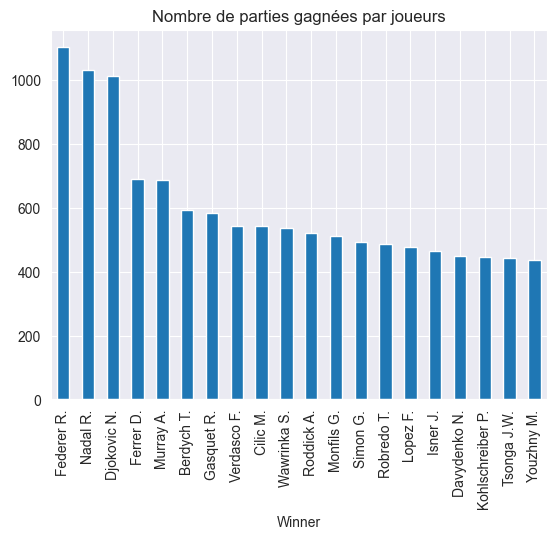

In [10]:
# Victoires par Joueur sorted
df.Winner.value_counts().nlargest(20).plot(kind='bar',title="Nombre de parties gagnées par joueurs")

<Axes: title={'center': 'Nombre de parties perdues par joueurs'}, xlabel='Loser'>

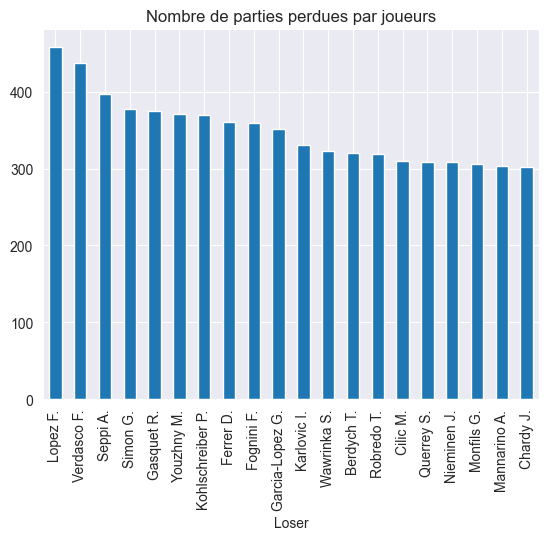

In [11]:
# Victoires par Joueur sorted
df.Loser.value_counts().nlargest(20).plot(kind='bar',title="Nombre de parties perdues par joueurs")

In [222]:
# Création du DataFrame df_player 
# player
# total play
# wins
# loses

losers = df['Loser'].unique()
winners = df['Winner'].unique()
players = np.concatenate([losers,winners])
players = np.unique(players)

players_total_play = []
players_wins = []
players_loses = []
players_odds = []

for player in players : 
    players_total_play.append(len(df.loc[df['Winner']==player]) + len(df.loc[df['Loser']==player]))
    players_wins.append(len(df.loc[df['Winner']==player]))
    players_loses.append(len(df.loc[df['Loser']==player]))
    players_odds.append((df.loc[df['Winner']==player].B365W.mean() + df.loc[df['Loser']==player].B365L.mean())/2)


d = {'player': players, 
     'games': players_total_play, 
     'wins':players_wins, 
     'loses':players_loses,
     'players_odds':players_odds}
df_players = pd.DataFrame(data=d)
df_players["ratio_win"] = df_players["wins"]/df_players["games"]


<Axes: title={'center': 'Ratio victoires par parties'}, xlabel='player'>

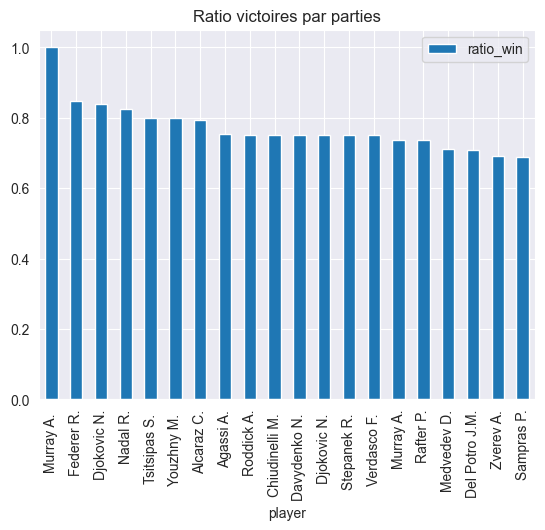

In [13]:
df_players.nlargest(20,"ratio_win").plot(kind='bar', y="ratio_win", x='player',title="Ratio victoires par parties")

In [14]:
# attention au diagramme ci-dessus, on observe que des joueurs avec peu de matchs peuvent avoir un ratio parfait
df_players.sort_values('ratio_win',ascending=False)

,player,games,wins,loses,ratio_win
990,Murray A.,5,5,0,1.000000
415,Federer R.,1299,1101,198,0.847575
347,Djokovic N.,1207,1012,195,0.838442
995,Nadal R.,1248,1031,217,0.826122
1431,Tsitsipas S.,5,4,1,0.800000
...,...,...,...,...,...
746,Krall L.,1,0,1,0.000000
745,Kralert P.,1,0,1,0.000000
1175,Riba-Madrid P.,2,0,2,0.000000
281,Cox D.,5,0,5,0.000000


In [15]:
df_players.nlargest(20,"games")

,player,games,wins,loses,ratio_win
415,Federer R.,1299,1101,198,0.847575
995,Nadal R.,1248,1031,217,0.826122
347,Djokovic N.,1207,1012,195,0.838442
420,Ferrer D.,1050,689,361,0.656190
1483,Verdasco F.,981,544,437,0.554536
477,Gasquet R.,958,583,375,0.608559
830,Lopez F.,935,477,458,0.510160
989,Murray A.,932,687,245,0.737124
125,Berdych T.,913,593,320,0.649507
1307,Simon G.,869,491,378,0.565017


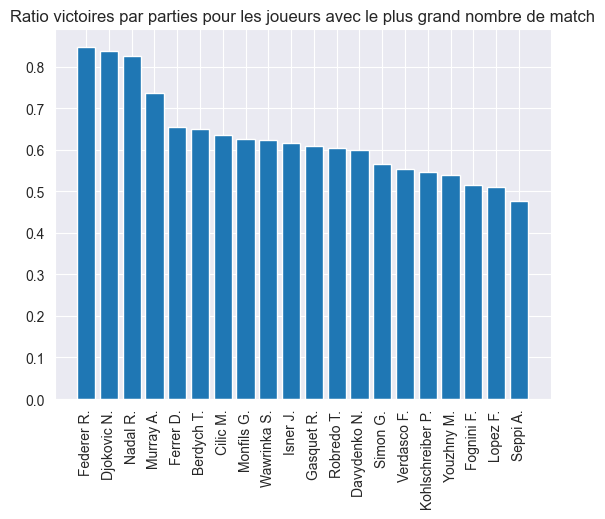

In [206]:
data = df_players.nlargest(20,"games").sort_values("ratio_win",ascending=False)

plt.bar(data.player, data.ratio_win)
plt.title("Ratio victoires par parties pour les joueurs avec le plus grand nombre de match")
plt.xticks(rotation='vertical')
plt.show()

In [221]:
# cote associée et rentabilité
data = df_players.nlargest(20,"games").sort_values("ratio_win",ascending=False)
data.head()

,player,games,wins,loses,players_odds,ratio_win
415,Federer R.,1299,1101,198,2.850666,0.847575
347,Djokovic N.,1207,1012,195,2.714721,0.838442
995,Nadal R.,1248,1031,217,2.773998,0.826122
989,Murray A.,932,687,245,2.209708,0.737124
420,Ferrer D.,1050,689,361,1.960534,0.656190


C:\Users\chbou\AppData\Local\Temp\ipykernel_11384\50397846.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(data.player, rotation='vertical')


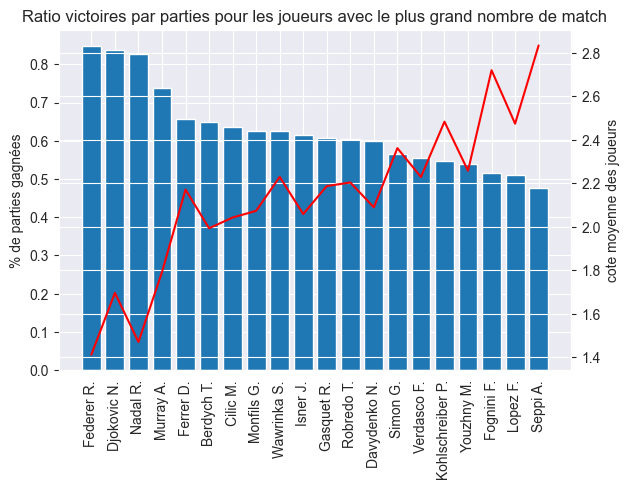

In [224]:
# cote associée et rentabilité
data = df_players.nlargest(20,"games").sort_values("ratio_win",ascending=False)

fig, ax1 = plt.subplots()
ax1.bar(data.player, data.ratio_win)
ax1.set_ylabel('% de parties gagnées')
ax1.set_xticklabels(data.player, rotation='vertical')

ax2 = ax1.twinx() 
ax2.set_ylabel('cote moyenne des joueurs')
ax2.plot(data.player, data.players_odds, color='red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Ratio victoires par parties pour les joueurs avec le plus grand nombre de match")
plt.show()



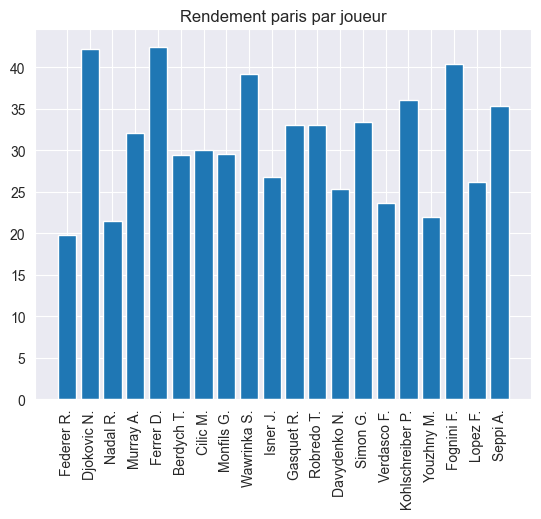

In [231]:
plt.bar(data.player, 100*(data.ratio_win*data.players_odds-1))
plt.title("Rendement paris par joueur")
plt.xticks(rotation='vertical')
plt.show()

C:\Users\chbou\AppData\Local\Temp\ipykernel_11384\58849252.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(data.player, rotation='vertical')


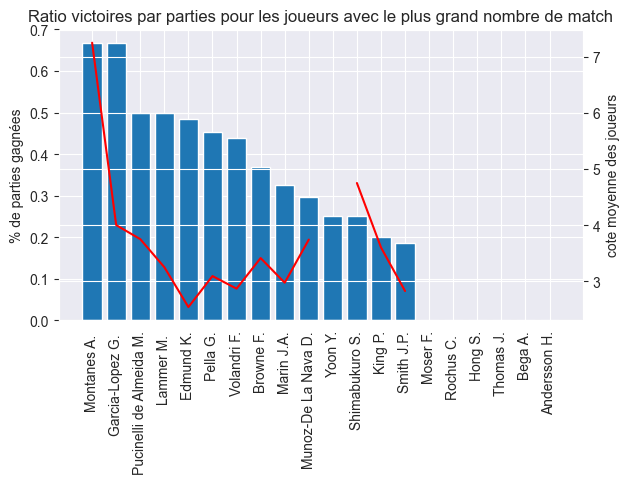

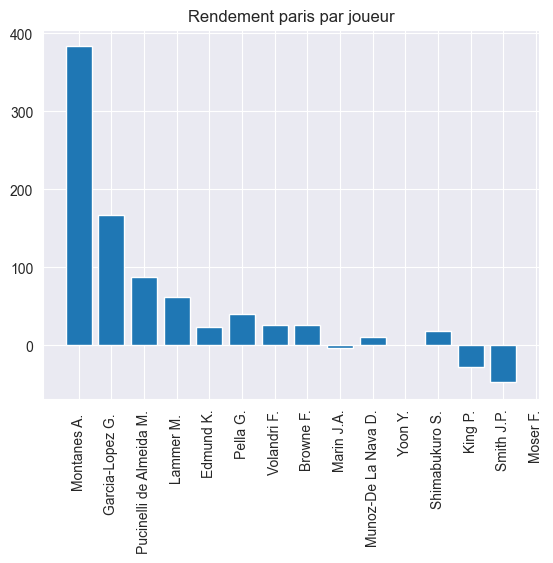

In [236]:
data = df_players.sample(20).sort_values("ratio_win",ascending=False)

fig, ax1 = plt.subplots()
ax1.bar(data.player, data.ratio_win)
ax1.set_ylabel('% de parties gagnées')
ax1.set_xticklabels(data.player, rotation='vertical')

ax2 = ax1.twinx() 
ax2.set_ylabel('cote moyenne des joueurs')
ax2.plot(data.player, data.players_odds, color='red')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Ratio victoires par parties pour les joueurs avec le plus grand nombre de match")
plt.show()

plt.bar(data.player, 100*(data.ratio_win*data.players_odds-1))
plt.title("Rendement paris par joueur")
plt.xticks(rotation='vertical')
plt.show()

##### Influence du court (extérieur/intérieur) par joueur

In [17]:
# influence du court (extérieur/intérieur) par joueur
indoors_win = []
indoors_loss= []
outdoors_win = []
outdoors_loss= []

for player in players : 
    winner_values = df.loc[df['Winner']==player]["Court"].value_counts()
    if hasattr(winner_values, 'Indoor'):
        indoors_win.append(winner_values.Indoor)
    else: 
        indoors_win.append(0)

    if hasattr(winner_values, 'Outdoor'):
        outdoors_win.append(winner_values.Outdoor)
    else:
        outdoors_win.append(0)

    loser_values = df.loc[df['Loser']==player]["Court"].value_counts()
    if hasattr(loser_values, 'Indoor'):
        indoors_loss.append(loser_values.Indoor)
    else:
        indoors_loss.append(0)
        
    if hasattr(loser_values, 'Outdoor'):
        outdoors_loss.append(loser_values.Outdoor)
    else:
        outdoors_loss.append(0)

df_players["indoors_win"] = indoors_win
df_players["indoors_loss"] = indoors_loss
df_players["outdoors_win"] = outdoors_win
df_players["outdoors_loss"] = outdoors_loss

In [18]:
df_players.head()

,player,games,wins,loses,ratio_win,indoors_win,indoors_loss,outdoors_win,outdoors_loss
0,Hajek J.,2,1,1,0.500000,0,0,1,1
1,Abdulla M.,1,0,1,0.000000,0,0,0,1
2,Abel M.,7,2,5,0.285714,0,0,2,5
3,Acasuso J.,321,160,161,0.498442,8,16,152,145
4,Adaktusson J.,1,0,1,0.000000,0,0,0,1


<Axes: title={'center': 'Ratio victoires par type de terrain (outdoor=0.5, indoor=-0.5) pour les 50 premiers joueurs au nombre de parties'}, xlabel='player'>

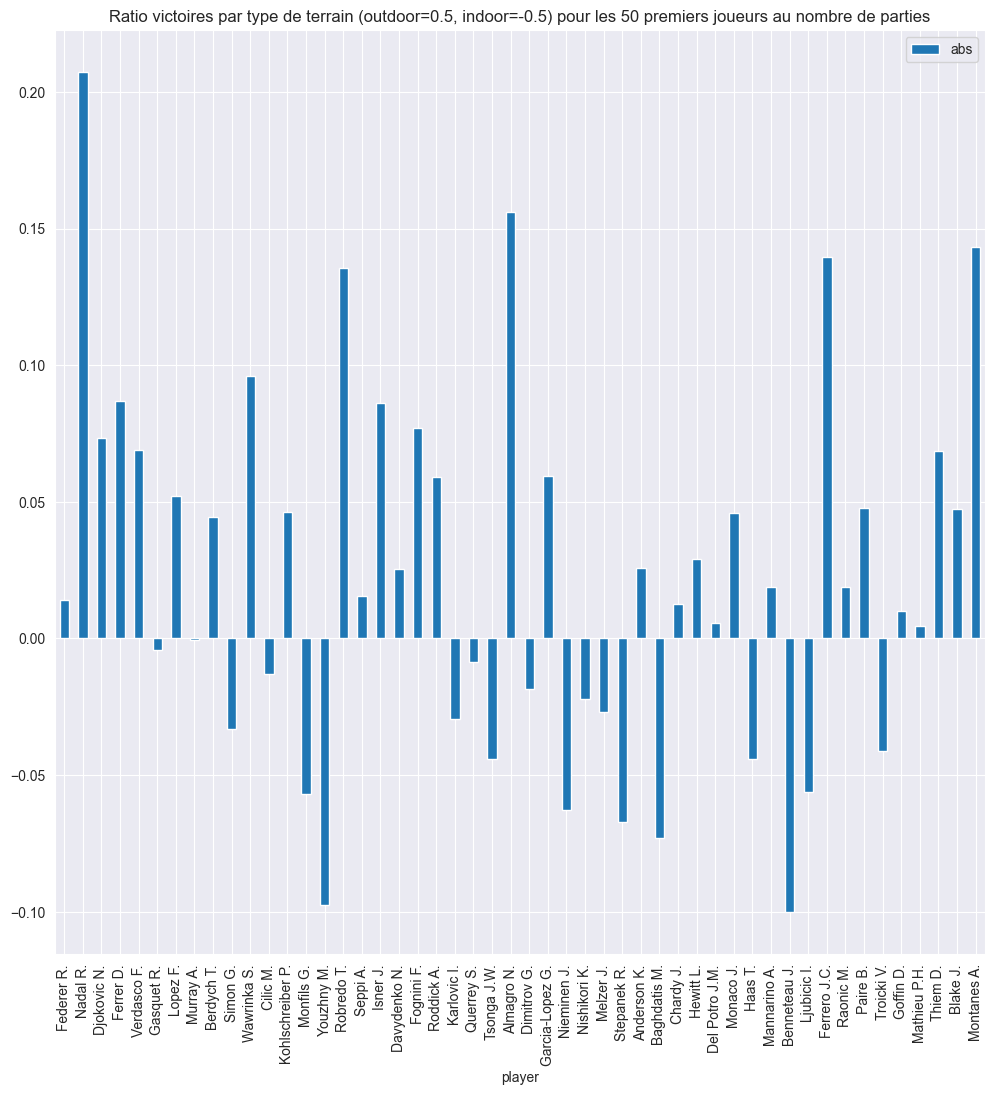

In [19]:
df_players["players_indoors_win_ratio"] = df_players.indoors_win / (df_players.indoors_win + df_players.indoors_loss)
df_players["players_outdoors_win_ratio"] = df_players.outdoors_win / (df_players.outdoors_win + df_players.outdoors_loss)
df_players["abs"] = (df_players.players_outdoors_win_ratio - df_players.players_indoors_win_ratio)
df_players.nlargest(50,"games").plot(kind='bar', y="abs" , x='player',title="Ratio victoires par type de terrain (outdoor=0.5, indoor=-0.5) pour les 50 premiers joueurs au nombre de parties",figsize=(12,12))

On observe que l'étude de cette feature peut être pertinente pour quelques joueurs.

##### Influence de la surface par joueur

Note : les surfaces "carpet" ne sont plus utilisées depuis 2009.

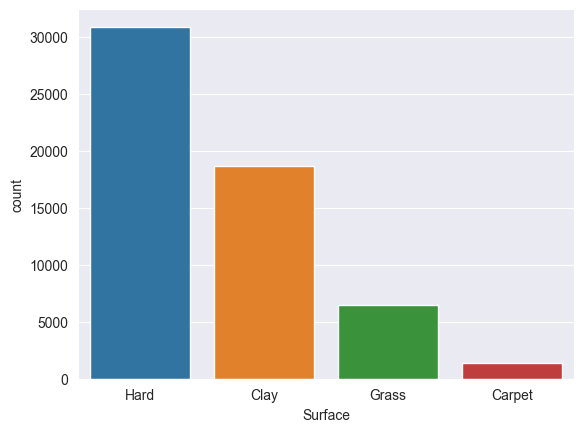

In [250]:
sns.countplot(x='Surface',data=df, order= df.Surface.value_counts().index);

In [20]:
surface_win_hard = []
surface_win_clay = []
surface_win_grass = []
surface_win_carpet = []
surface_loss_hard = []
surface_loss_clay = []
surface_loss_grass = []
surface_loss_carpet = []

for player in players : 
    winner_values = df.loc[df['Winner']==player]["Surface"].value_counts() 
    if hasattr(winner_values, 'Hard'):
        surface_win_hard.append(winner_values.Hard)
    else:
        surface_win_hard.append(0)

    if hasattr(winner_values, 'Clay'):
        surface_win_clay.append(winner_values.Clay)
    else:
        surface_win_clay.append(0)

    if hasattr(winner_values, 'Grass'):
        surface_win_grass.append(winner_values.Grass)
    else:
        surface_win_grass.append(0)

    if hasattr(winner_values, 'Carpet'):
        surface_win_carpet.append(winner_values.Carpet)
    else:
        surface_win_carpet.append(0)
    

    loser_values = df.loc[df['Loser']==player]["Surface"].value_counts() 
    if hasattr(loser_values, 'Hard'):
        surface_loss_hard.append(loser_values.Hard)
    else:
        surface_loss_hard.append(0)

    if hasattr(loser_values, 'Clay'):
        surface_loss_clay.append(loser_values.Clay)
    else:
        surface_loss_clay.append(0)

    if hasattr(loser_values, 'Grass'):
        surface_loss_grass.append(loser_values.Grass)
    else:
        surface_loss_grass.append(0)

    if hasattr(loser_values, 'Carpet'):
        surface_loss_carpet.append(loser_values.Carpet)
    else:
        surface_loss_carpet.append(0)


df_players["surface_win_hard"] = surface_win_hard
df_players["surface_win_clay"] = surface_win_clay
df_players["surface_win_grass"] = surface_win_grass
df_players["surface_win_carpet"] = surface_win_carpet
df_players["surface_loss_hard"] = surface_loss_hard
df_players["surface_loss_clay"] = surface_loss_clay
df_players["surface_loss_grass"] = surface_loss_grass
df_players["surface_loss_carpet"] = surface_loss_carpet

<Axes: title={'center': 'Ratio victoires (-0.5 0.5) par type de surface pour les 20 premiers joueurs au nombre de parties'}, xlabel='player'>

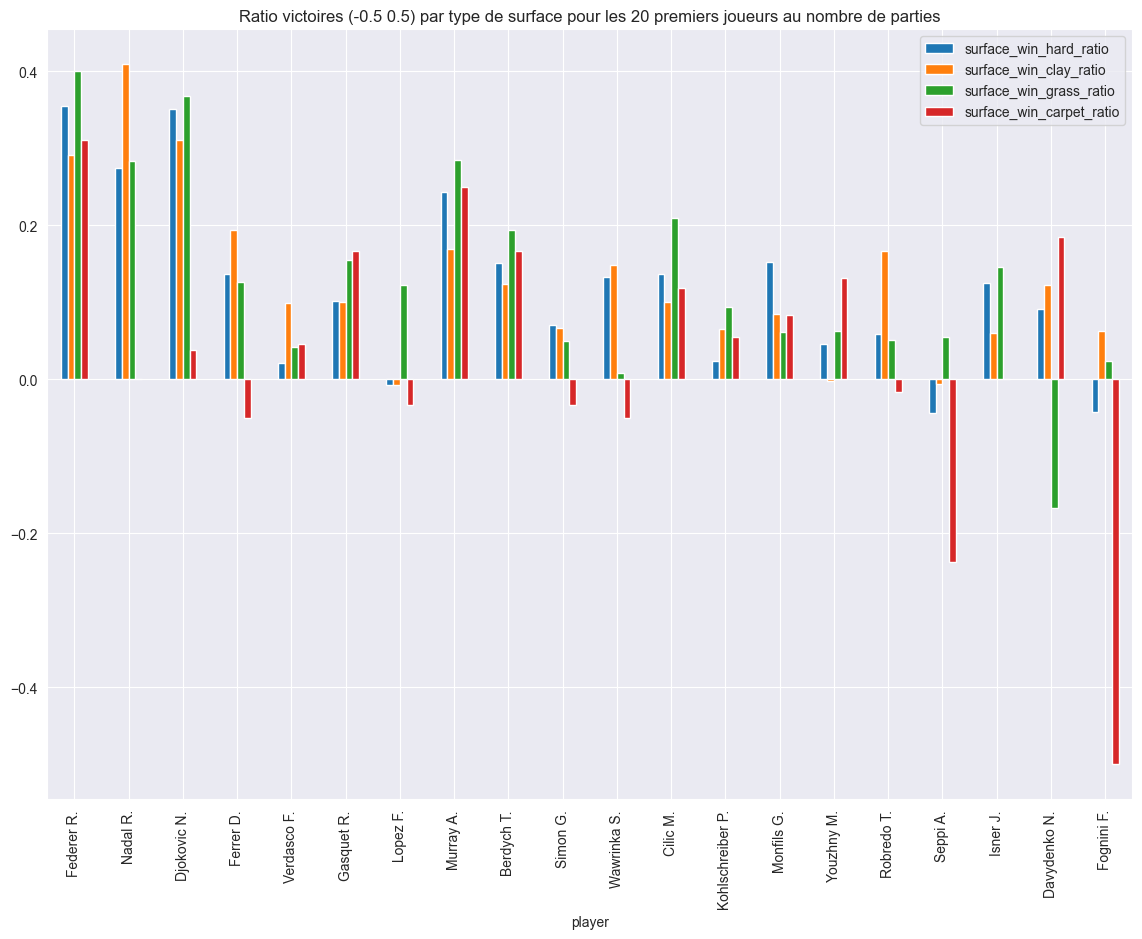

In [21]:
df_players["surface_win_hard_ratio"] =(df_players.surface_win_hard / (df_players.surface_win_hard + df_players.surface_loss_hard))-0.5
df_players["surface_win_clay_ratio"] = (df_players.surface_win_clay / (df_players.surface_win_clay + df_players.surface_loss_clay))-0.5
df_players["surface_win_grass_ratio"] = (df_players.surface_win_grass / (df_players.surface_win_grass + df_players.surface_loss_grass))-0.5
df_players["surface_win_carpet_ratio"] = (df_players.surface_win_carpet / (df_players.surface_win_carpet + df_players.surface_loss_carpet))-0.5
df_players.nlargest(20,"games").plot(kind='bar', 
y=["surface_win_hard_ratio","surface_win_clay_ratio","surface_win_grass_ratio","surface_win_carpet_ratio"] , 
x='player',
title="Ratio victoires (-0.5 0.5) par type de surface pour les 20 premiers joueurs au nombre de parties",
figsize=(14,10))



On en conclue que la surface de terrain a son importance et doit être gardé comme feature.

##### Analyse du rank ATP

In [114]:
best_rank_win = df.loc[df['WRank']<df['LRank']]['WRank'].count()
total_match = df.WRank.count()

print(round(100*best_rank_win /total_match,2), "% des joueurs qui ont un meilleur rank ATP gagnent le match") 

65.11 % des joueurs qui ont un meilleur rank ATP gagnent le match


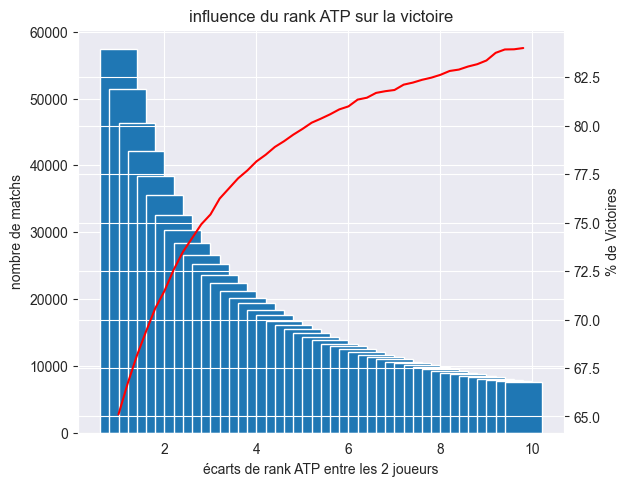

In [156]:
# Est ce que l'écart de rank est significatif sur le résultat du match ?
ecarts = np.arange(1,10,0.2)
probas=[]
matchs=[]
for ecart in ecarts:
    best_rank_win = df.loc[(df['WRank']*ecart)<(df['LRank'])]['WRank'].count()
    best_rank_loss = df.loc[(df['LRank']*ecart)<(df['WRank'])]['WRank'].count()
    #print(best_rank_win, "  ", best_rank_loss)
    proba = 100*best_rank_win /(best_rank_win+ best_rank_loss)
    match = best_rank_win + best_rank_loss
    matchs.append(match)
    probas.append(proba)


fig, ax1 = plt.subplots()
ax1.set_xlabel('écarts de rank ATP entre les 2 joueurs')
ax1.set_ylabel('nombre de matchs') 
ax1.bar(ecarts, matchs)

ax2 = ax1.twinx() 
ax2.set_ylabel('% de Victoires')
ax2.plot(ecarts, probas, color='red')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("influence du rank ATP sur la victoire")
plt.show()


Le rank ATP (et leurs écarts entre joueurs) a une importante corrélation avec la victoire.  
On note que même avec avec de grands écarts on a un jeu de données suffisantes(10 000 parties pour un écart ATP conséquent de 8).

##### Evolution de la performance du joueur dans le temps

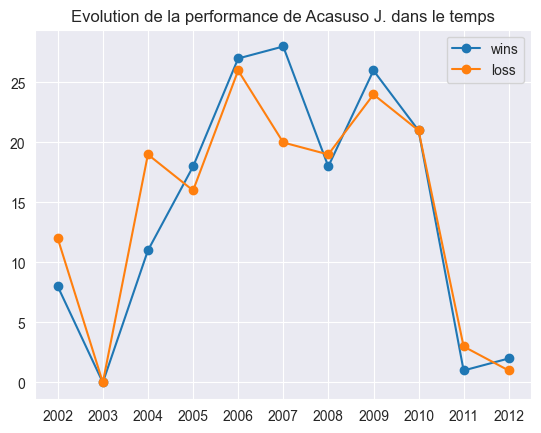

In [262]:
player = players[3]
#player = "Rublev A."
#player = "De Minaur A."
#player = "Diallo G."
df.Date = pd.to_datetime(df.Date)
freq = '1Y'
wins = df.loc[df['Winner']==player].groupby(pd.Grouper(key='Date', freq=freq))['Winner'].count()
loss = df.loc[df['Loser']==player].groupby(pd.Grouper(key='Date', freq=freq))['Loser'].count()

#print(wins)
#print(loss)

if not (wins.empty):
    wins, = plt.plot(wins, marker="o")
if not (loss.empty):
    loss, = plt.plot(loss, marker="o")
title = "Evolution de la performance de " + player + " dans le temps"
plt.legend((wins,loss),('wins','loss'), loc = 'best')
plt.title(title)
plt.show()

Les victoires et défaites des joueurs sont très inconsistantes dans le temps.  
En l'état cela ne parait pas généralisable.

##### Analyse par tournoi

Text(0, 0.5, 'Nombre de tournoi')

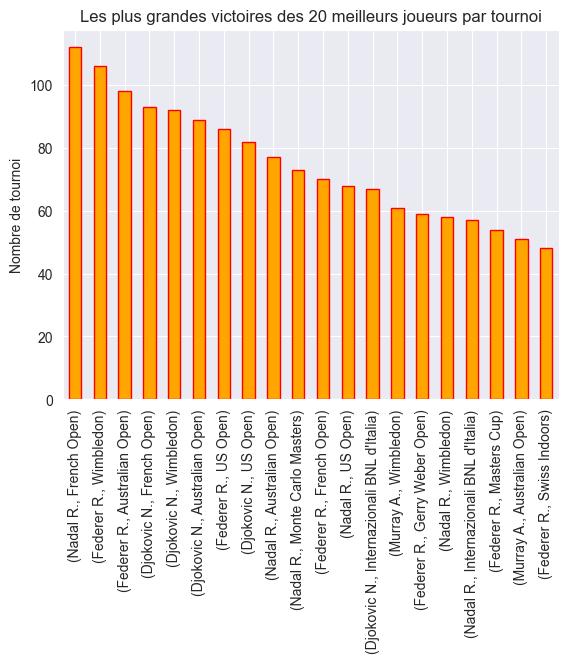

In [23]:
data=pd.concat([df.Winner,df.Tournament],axis=1).groupby('Winner').value_counts().nlargest(20)
data.plot(kind='bar',color='orange',edgecolor='red')
plt.title('Les plus grandes victoires des 20 meilleurs joueurs par tournoi')
plt.xlabel('')
plt.ylabel('Nombre de tournoi')

C:\Users\chbou\AppData\Local\Temp\ipykernel_11384\1347515914.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data=df[df.Winner.isin(df.Winner.value_counts().nlargest(10).index.values)]\


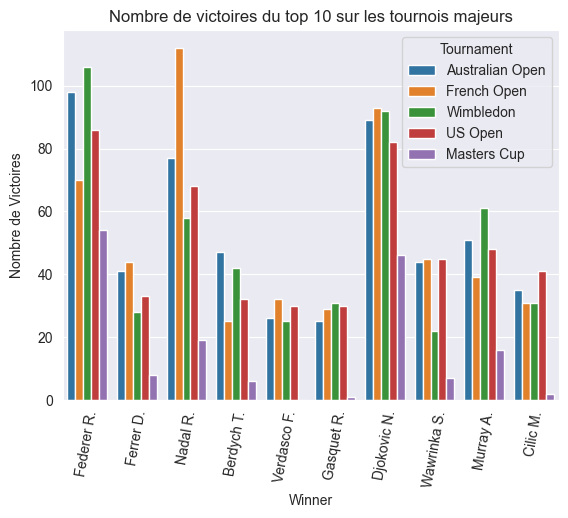

In [24]:
data=df[df.Winner.isin(df.Winner.value_counts().nlargest(10).index.values)]\
[df.Tournament.isin(['Australian Open','Wimbledon','US Open','French Open','Masters Cup'])]
sns.countplot(x='Winner',hue='Tournament',data=data)
plt.xticks(rotation=80)
plt.ylabel('Nombre de Victoires')
plt.title('Nombre de victoires du top 10 sur les tournois majeurs')
plt.show()

### 4. Modèle

Question pour le modèle :
- déterminer quand parier et quand ne pas parier : construire un score de confidence et jouer uniquement quand >X ? 
- l'historique peut etre utile pour certains joueurs mais pas pour d'autres, est il possible de faire en sorte que cette feature ne s'active que sous certaines conditions ? (= une certaine quantité de match récent par exemple)

réflexion pour le modèle :
PLutot que la probabilité d'un pari, on pourrait détemriner le succès sur une fenetre roulante : X matchs

player1name, player1feature1, player1feature2, player1featuren,  player2name, player2feature1, player2feature2, player2featuren,  matchfeature1, winner
1
0
name1, surfarcehard1, name2, surfarcehard2, winner
jokovic,  0.8, federer, 0.3, 1
jokivic,  0.82, intel, 0.81, 1